**ПЕРВАЯ ЧАСТЬ**

**Название и описание проекта: телекоммуникации**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**
<br><br>
Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).
<br><br>
Также доступны такие услуги:
- интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- выделенная линия технической поддержки (TechSupport);
- облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).
<br><br>
За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. 
<br>Доступны различные способы расчёта и возможность получения электронного чека.


**Описание данных**
<br><br>
Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.
<br>
Во всех файлах столбец customerID содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020.


**Цель проекта**
<br><br>
Предложить оператору связи модель для возможности прогнозирования оттока клиентов.

## Знакомство с данными

**Загрузка данных:**

In [78]:
!pip install scikit-learn==1.1.3
!pip install phik

import pandas as pd 
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV, train_test_split)
from sklearn.linear_model import Ridge
from sklearn.preprocessing import normalize, Normalizer, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder, StandardScaler)
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer


from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import phik
from phik.report import plot_correlation_matrix
from phik import report, resources

from catboost import CatBoostClassifier, Pool, cv

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 250923

In [2]:
try:
    contract = pd.read_csv('/datasets/contract_new.csv')
    internet = pd.read_csv('/datasets/internet_new.csv')
    personal = pd.read_csv('/datasets/personal_new.csv')
    phone = pd.read_csv('/datasets/phone_new.csv')
except:
    contract = pd.read_csv('datasets/contract_new.csv')
    internet = pd.read_csv('datasets/internet_new.csv')
    personal = pd.read_csv('datasets/personal_new.csv')
    phone = pd.read_csv('datasets/phone_new.csv')

**Исследование каждого датафрейма:**

In [3]:
# выводим сводную информацию по датасетам:
data = [contract, internet, personal, phone]
for data in (data):
    print(data.head())
    print(data.info())
    print(data.describe())

   customerID   BeginDate EndDate            Type PaperlessBilling  \
0  7590-VHVEG  2020-01-01      No  Month-to-month              Yes   
1  5575-GNVDE  2017-04-01      No        One year               No   
2  3668-QPYBK  2019-10-01      No  Month-to-month              Yes   
3  7795-CFOCW  2016-05-01      No        One year               No   
4  9237-HQITU  2019-09-01      No  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges  
0           Electronic check           29.85        31.04  
1               Mailed check           56.95      2071.84  
2               Mailed check           53.85       226.17  
3  Bank transfer (automatic)           42.30       1960.6  
4           Electronic check           70.70        353.5  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID    

**Выводы по этапу исследования датафреймов:**
<br>
1. Contract:

- 7043 записи;
- требуется изменить тип данных признаков BeginDate, EndDate на datetime, MonthlyCharges, TotalCharges на float.

2. Internet: 

- 5517 записей;
- все признаки кроме customerID - категориальные.

3. Personal: 
- 7043 записи;
- все признаки кроме customerID - категориальные.

4. Phone: 
- 6361 запись;
- все признаки кроме customerID - категориальные.
<br><br>
Таблицы необходимо объединить в одну, отработав получившиеся пропуски данных.

**План работы над проектом:**

1. Знакомство с данными (загрузка данных, исследовательский анализ, описание данных, визуализация распределений признаков, первые выводы).
2. Предобработка данных (объединение данных в один датасёт; обработка аномалий, пропусков, выбросов, выявление зависимости признаков, предварительные выводы и формирование плана дальнейших действий).
3. Подготовка и обучение моделей машинного обучения (разделение на выборки, кодирование, масштабирование, подбор гиперпараметров, кросс-валидация).
4. Выбор лучшей модели, проверка качества модели на тестовой выборке, финальные выводы, анализ лучшей модели (важность признаков, матрица ошибок).
5. Формирование отчёта по полученным данным.

**Вопросы:**
<br><br>
Вопросов нет

## Предобработка данных

**Объединение датафреймов**

In [4]:
data = contract.merge(personal, how='left', on='customerID').merge(internet, how='left', on='customerID').merge(
    phone, how='left', on='customerID')
data = data.set_index('customerID')
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

In [6]:
data.shape

(7043, 19)

Изменим тип данных признаков  MonthlyCharges, TotalCharges на float на float.

In [7]:
# изменяем тип данных признаков MonthlyCharges и TotalCharges на float.
data['MonthlyCharges'] = pd.to_numeric(data['MonthlyCharges'], errors='coerce')
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')

In [8]:
# проверяем
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7032 non-null   float64
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

Поменяли тип данных у признаков:  
- MonthlyCharges, TotalCharges - на float.

Далее ещё поменяем тип данных:
- BeginDate, EndDate - на datetime.  

Остальные признаки будут обработаны как категориальные.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7032 non-null   float64
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

После слияния баз, в объединенном датасете теперь есть пропуски. 
<br>
Что можно с ними сделать:
1. Удалить пропуски и для построения модели использовать остаточные данные (но такой вариант повлечёт потерю в 31% данных). 
2. Заполнить пропуски. 

Выбираем второй вариант, данных и так мало, мы не можем себе позволить потерять ещё больше, поэтому пропуски будем однозначно заполнять.

**Обработка пропусков**

Посмотрим на каждый признак, где есть пропуски, какие данные содержит, какое количество и чем их можем заполнить.

Признак TotalCharges

In [10]:
data['TotalCharges'].unique()

array([  31.04, 2071.84,  226.17, ...,  325.6 ,  520.8 , 7251.82])

В признаке TotalCharges пропуски означают скорее всего 0, поэтому будем заполнять нулями.

In [11]:
data['TotalCharges'] = data['TotalCharges'].fillna(0)

Признак gender

In [12]:
data['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

Необходимо преобразовать значения этого признака в числовые

In [13]:
data['gender'] = (data['gender'] == 'Male').astype('int')

In [14]:
data['gender'] 

customerID
7590-VHVEG    0
5575-GNVDE    1
3668-QPYBK    1
7795-CFOCW    1
9237-HQITU    0
             ..
6840-RESVB    1
2234-XADUH    0
4801-JZAZL    0
8361-LTMKD    1
3186-AJIEK    1
Name: gender, Length: 7043, dtype: int64

Признак InternetService

In [15]:
data['InternetService'].value_counts(normalize=True)

Fiber optic    0.561175
DSL            0.438825
Name: InternetService, dtype: float64

In [16]:
data['InternetService'].isnull().sum()

1526

Заполним пропуски отсутствующим значением "none"

In [17]:
data['InternetService'] = data['InternetService'].fillna('none')
data['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
none           1526
Name: InternetService, dtype: int64

Признак OnlineSecurity

In [18]:
data['OnlineSecurity'].value_counts(normalize=True)

No     0.63404
Yes    0.36596
Name: OnlineSecurity, dtype: float64

In [19]:
data['OnlineSecurity'].isnull().sum()

1526

В признаках в данных которых только две категории "yes" и "no", вероятнее всего пропуск значения это - "no", поэтому заполним их так

In [20]:
data['OnlineSecurity'] = data["OnlineSecurity"].fillna('No')

Признак OnlineBackup

In [21]:
data['OnlineBackup'].value_counts(normalize=True)

No     0.559724
Yes    0.440276
Name: OnlineBackup, dtype: float64

In [22]:
data['OnlineBackup'].isnull().sum()

1526

In [23]:
data['OnlineBackup'] = data['OnlineBackup'].fillna('No')

Признак DeviceProtection

In [24]:
data['DeviceProtection'].value_counts(normalize=True)

No     0.560993
Yes    0.439007
Name: DeviceProtection, dtype: float64

In [25]:
data['DeviceProtection'].isnull().sum()

1526

In [26]:
data['DeviceProtection'] = data['DeviceProtection'].fillna('No')

Признак TechSupport

In [27]:
data['TechSupport'].value_counts(normalize=True)

No     0.629509
Yes    0.370491
Name: TechSupport, dtype: float64

In [28]:
data['TechSupport'].isnull().sum()

1526

In [29]:
data['TechSupport'] = data['TechSupport'].fillna('No')

Признак StreamingTV

In [30]:
data['StreamingTV'].value_counts(normalize=True)

No     0.509335
Yes    0.490665
Name: StreamingTV, dtype: float64

In [31]:
data['StreamingTV'].isnull().sum()

1526

In [32]:
data['StreamingTV'] = data['StreamingTV'].fillna('No')

Признак StreamingMovies

In [33]:
data['StreamingMovies'].value_counts(normalize=True)

No     0.504803
Yes    0.495197
Name: StreamingMovies, dtype: float64

In [34]:
data['StreamingMovies'].isnull().sum()

1526

In [35]:
data['StreamingMovies'] = data["StreamingMovies"].fillna('No')

Признак MultipleLines

In [36]:
data['MultipleLines'].value_counts(normalize=True)

No     0.532935
Yes    0.467065
Name: MultipleLines, dtype: float64

In [37]:
data['MultipleLines'].isnull().sum()

682

In [38]:
data['MultipleLines'] = data['MultipleLines'].fillna('No')

**Новые признаки**

Создадим новый признак Target – нашей целевой переменной при построении модели машинного обучения для прогнозирования оттока клиентов

In [39]:
data['Target'] = (data['EndDate'] != 'No').astype('int')

Признаки EndDate и BeginDate

In [40]:
# так как в столбце EndDate значения "No", то заполним финальной датой этого датасета - 1 февраля 2020 года
data['EndDate'] = data['EndDate'].where(data['EndDate'] != 'No', '2020-02-01')

Изменим тип данных признаков BeginDate, EndDate на datetime

In [41]:
data['EndDate'] = pd.to_datetime(data['EndDate'])
data['BeginDate'] = pd.to_datetime(data['BeginDate'])

Создадим признак длительности жизни клиента в днях

In [42]:
data['Duration'] = (data['EndDate'] - data['BeginDate']).dt.days

In [43]:
data['Duration']

customerID
7590-VHVEG      31
5575-GNVDE    1036
3668-QPYBK     123
7795-CFOCW    1371
9237-HQITU     153
              ... 
6840-RESVB     730
2234-XADUH    2191
4801-JZAZL     337
8361-LTMKD     215
3186-AJIEK    2010
Name: Duration, Length: 7043, dtype: int64

В категориальных бинарных признаках со значениями yes/no заменим на числовые:

In [44]:
for column in data:
    tmp = data[column].unique()
    tmp.sort()
    if list(tmp) == ['No', 'Yes']:
        data[column] = (data[column] == 'Yes').astype('int')
        data[column] = data[column].astype('int')

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   int64         
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   gender            7043 non-null   int64         
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   int64         
 10  Dependents        7043 non-null   int64         
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   int64         
 13  OnlineBackup      7043 non-null   int64         
 14  DeviceProtecti

**Удаление признаков**

В этой работе нам необходимо удалить признаки, связанные с датами.

In [46]:
del data['BeginDate'], data['EndDate']

Проверим датасет после предобработки

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int64  
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   int64  
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   int64  
 8   Dependents        7043 non-null   int64  
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   int64  
 11  OnlineBackup      7043 non-null   int64  
 12  DeviceProtection  7043 non-null   int64  
 13  TechSupport       7043 non-null   int64  
 14  StreamingTV       7043 non-null   int64  
 15  StreamingMovies   7043 non-null   int64  
 16  MultipleLines     7043 non-null 

Проверим дисбаланс классов

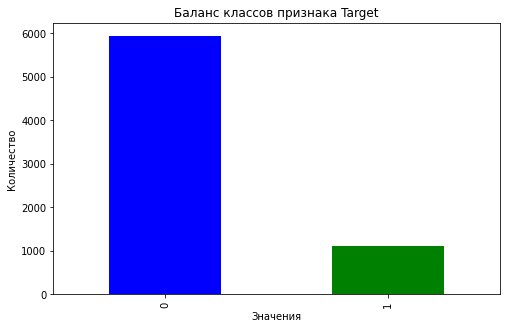

In [48]:
ig, ax = plt.subplots(1)
ax.set_title('Баланс классов признака Target')
ax.set_xlabel('Значения')
ax.set_ylabel('Количество')

data['Target'].value_counts().plot(kind='bar', figsize=(8, 5), ax=ax, color=['blue', 'green'])

plt.show()

Проверим корреляцию и постром график для того, чтобы понять как распределяются данные в числовых признаках

In [49]:
data[['MonthlyCharges', 'TotalCharges', 'Duration']].corr()

,MonthlyCharges,TotalCharges,Duration
MonthlyCharges,1.000000,0.630440,0.220054
TotalCharges,0.630440,1.000000,0.821746
Duration,0.220054,0.821746,1.000000


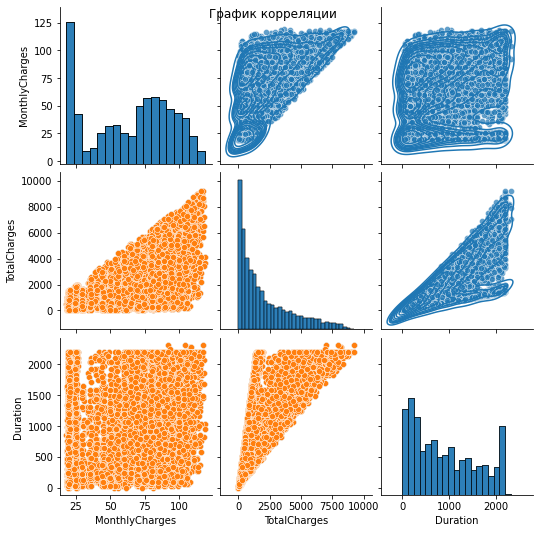

In [50]:
plot = sns.pairplot(data[['MonthlyCharges', 'TotalCharges', 'Duration']], palette='Set1', 
                    markers=['o', 's', 'D'], plot_kws={'alpha': 0.7})
plot.map_upper(sns.kdeplot)
plot.map_lower(sns.scatterplot)
plot.map_diag(sns.histplot)

plt.suptitle("График корреляции")

plt.show()

Данные представлены в подавляющем большинстве в категориальных признаках. Корреляция Пирсона с такой ситуацией не сработает. Поэтому, чтобы посмотреть корреляцияю, используем коэффициент корреляции phik.


Посмотрим коэффициент корреляции Phik:
- проверим наличие мультиколеарности
- удалим лишние признаки, если они есть
- отберем важные признаки для обучения модели. 

In [51]:
phik_report = data.phik_matrix()
phik_report.round(2)

interval columns not set, guessing: ['PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines', 'Target', 'Duration']


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target,Duration
Type,1.00,0.11,0.28,0.39,0.47,0.00,0.09,0.18,0.15,0.51,0.15,0.10,0.14,0.18,0.07,0.07,0.07,0.09,0.63
PaperlessBilling,0.11,1.00,0.37,0.47,0.20,0.00,0.24,0.01,0.17,0.23,0.00,0.20,0.16,0.06,0.34,0.33,0.25,0.08,0.03
PaymentMethod,0.28,0.37,1.00,0.40,0.34,0.00,0.29,0.24,0.22,0.32,0.26,0.28,0.31,0.27,0.38,0.38,0.34,0.21,0.35
MonthlyCharges,0.39,0.47,0.40,1.00,0.71,0.01,0.30,0.20,0.18,0.92,0.55,0.63,0.67,0.58,0.84,0.83,0.68,0.23,0.39
TotalCharges,0.47,0.20,0.34,0.71,1.00,0.00,0.14,0.38,0.08,0.49,0.52,0.62,0.64,0.55,0.64,0.64,0.57,0.30,0.85
gender,0.00,0.00,0.00,0.01,0.00,1.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00
SeniorCitizen,0.09,0.24,0.29,0.30,0.14,0.00,1.00,0.02,0.32,0.16,0.06,0.10,0.09,0.09,0.16,0.19,0.22,0.09,0.06
Partner,0.18,0.01,0.24,0.20,0.38,0.00,0.02,1.00,0.65,0.00,0.22,0.22,0.24,0.19,0.19,0.18,0.22,0.23,0.45
Dependents,0.15,0.17,0.22,0.18,0.08,0.00,0.32,0.65,1.00,0.11,0.12,0.03,0.01,0.10,0.02,0.06,0.03,0.05,0.20
InternetService,0.51,0.23,0.32,0.92,0.49,0.00,0.16,0.00,0.11,1.00,0.24,0.23,0.23,0.24,0.27,0.27,0.23,0.06,0.06


Визуализируем в виде графика

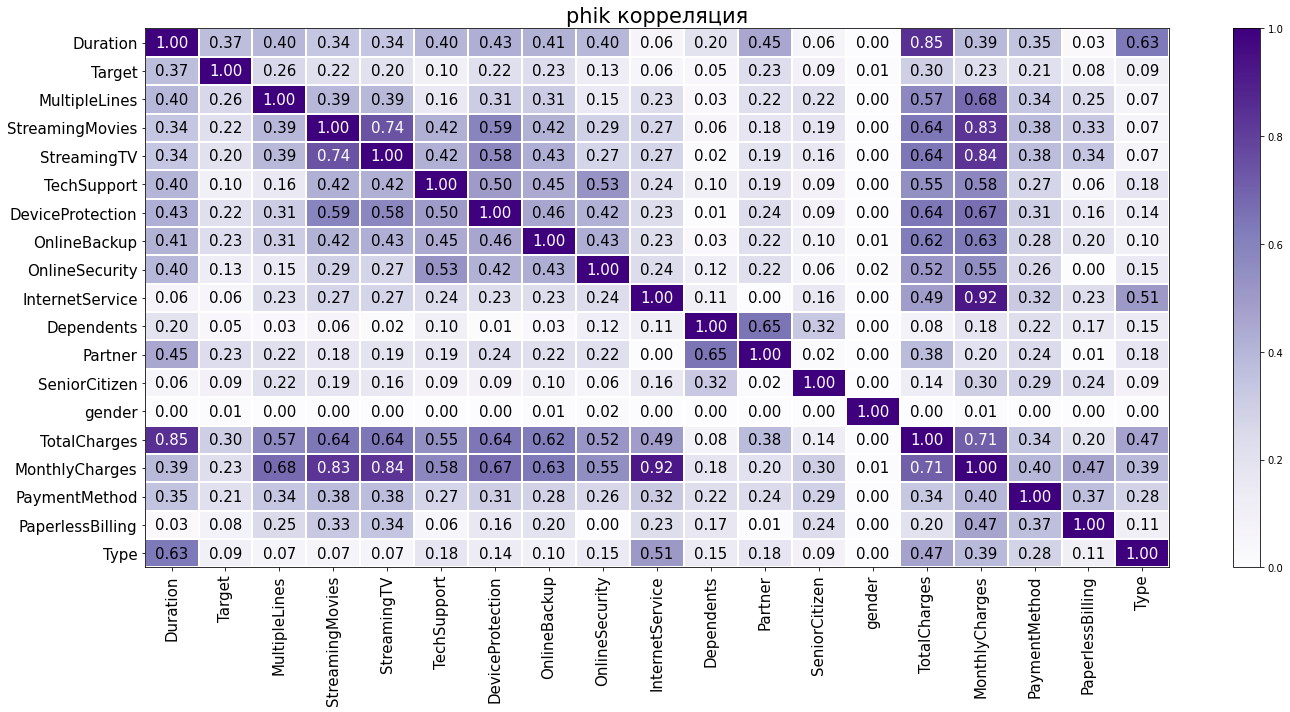

In [52]:
plot_correlation_matrix(phik_report.values,
                        x_labels=phik_report.columns,
                        y_labels=phik_report.index,
                        vmin=0,
                        vmax=1,
                        color_map="Purples",
                        title=r"phik корреляция",
                        fontsize_factor=1.5,
                        figsize=(20, 10))
plt.tight_layout()

Нужно будет удалить признак'TotalCharges', так как у него есть мультколлениарность с Duration (0.85) и  MonthlyCharges (0.71).   

In [53]:
phik_report['Target'].sort_values(ascending=False)

Target              1.000000
Duration            0.374569
TotalCharges        0.302890
MultipleLines       0.261237
OnlineBackup        0.229482
Partner             0.226688
MonthlyCharges      0.226280
StreamingMovies     0.222232
DeviceProtection    0.218380
PaymentMethod       0.214832
StreamingTV         0.200198
OnlineSecurity      0.132594
TechSupport         0.103652
Type                0.094015
SeniorCitizen       0.086159
PaperlessBilling    0.083398
InternetService     0.056621
Dependents          0.046871
gender              0.008581
Name: Target, dtype: float64

Оставим для обучения модели машинного обучения признаки с весом более 0,10: Target, Duration, MultipleLines, OnlineBackup, Partner, MonthlyCharges, StreamingMovies, DeviceProtection, PaymentMethod, StreamingTV, OnlineSecurity, TechSupport.


In [54]:
data_final = data[[
    'Target',
    'Duration',
    'MultipleLines',
    'OnlineBackup',
    'Partner',
    'MonthlyCharges',
    'StreamingMovies',
    'DeviceProtection',
    'PaymentMethod',
    'StreamingTV',
    'OnlineSecurity',
    'TechSupport'
]]

In [55]:
data_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Target            7043 non-null   int64  
 1   Duration          7043 non-null   int64  
 2   MultipleLines     7043 non-null   int64  
 3   OnlineBackup      7043 non-null   int64  
 4   Partner           7043 non-null   int64  
 5   MonthlyCharges    7043 non-null   float64
 6   StreamingMovies   7043 non-null   int64  
 7   DeviceProtection  7043 non-null   int64  
 8   PaymentMethod     7043 non-null   object 
 9   StreamingTV       7043 non-null   int64  
 10  OnlineSecurity    7043 non-null   int64  
 11  TechSupport       7043 non-null   int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 973.3+ KB


In [56]:
data_final.head()

,Target,Duration,MultipleLines,OnlineBackup,Partner,MonthlyCharges,StreamingMovies,DeviceProtection,PaymentMethod,StreamingTV,OnlineSecurity,TechSupport
customerID,,,,,,,,,,,,
7590-VHVEG,0,31,0,1,1,29.85,0,0,Electronic check,0,0,0
5575-GNVDE,0,1036,0,0,0,56.95,0,1,Mailed check,0,1,0
3668-QPYBK,0,123,0,1,0,53.85,0,0,Mailed check,0,1,0
7795-CFOCW,0,1371,0,0,0,42.30,0,1,Bank transfer (automatic),0,1,1
9237-HQITU,0,153,0,0,0,70.70,0,0,Electronic check,0,0,0


**Разделение на выборки**

Делим датасет на две выборки: train и test.
Test size – 0,25.

In [57]:
# определяем список признаков, которые будут использоваться для обучения модели и предсказания
features_names = [
    'Target',
    'Duration',
    'MultipleLines',
    'OnlineBackup',
    'Partner',
    'MonthlyCharges',
    'StreamingMovies',
    'DeviceProtection',
    'PaymentMethod',
    'StreamingTV',
    'OnlineSecurity',
    'TechSupport'
]
# определяем числовые признаки, которые потребуют масштабирования
numeric_features = ['Duration','MonthlyCharges']

# выбираем только необходимые признаки из исходного датасета.
data_features = data_final[features_names]

# выделяем целевую переменную (Target) для обучения модели
data_target = data_final['Target']

# разделяем данные на обучающую и тестовую выборки, задавая размер тестовой выборки в 25%
features_train, features_test, target_train, target_test = train_test_split(
    data_features, data_target, test_size=0.25, random_state=RANDOM_STATE)

features_train.shape, features_test.shape, data_final.shape


((5282, 12), (1761, 12), (7043, 12))

**Кодирование (с учётом используемых моделей)**

Для категориальных признаков проведем OHE (OneHotEncoder) кодирование и масштабирование:

In [58]:
# Определяем числовые и категориальные признаки
numeric_features = ['Duration', 'MonthlyCharges']
categorical_features = ['MultipleLines', 'OnlineBackup', 'Partner', 'StreamingMovies',
                        'DeviceProtection', 'PaymentMethod', 'StreamingTV', 'OnlineSecurity', 'TechSupport']

# Выбираем только необходимые признаки из исходного датасета
data_features = data_final[numeric_features + categorical_features]

# Выделяем целевую переменную (Target) для обучения модели
data_target = data_final['Target']

# Разделяем данные на обучающую и тестовую выборки
features_train, features_test, target_train, target_test = train_test_split(
    data_features, data_target, test_size=0.25, random_state=RANDOM_STATE)

# Создаем ColumnTransformer для кодирования категориальных признаков и масштабирования числовых
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ],
    remainder='passthrough'
)

# Применяем ColumnTransformer к обучающей и тестовой выборке
features_train_encoded = preprocessor.fit_transform(features_train)
features_test_encoded = preprocessor.transform(features_test)

# Преобразуем результаты в DataFrame с именами признаков
encoded_categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(encoded_categorical_features) + numeric_features
X_train = pd.DataFrame(features_train_encoded, columns=feature_names)
X_test = pd.DataFrame(features_test_encoded, columns=feature_names)



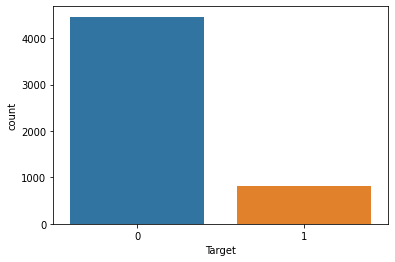

In [59]:
sns.countplot(target_train)
plt.show()

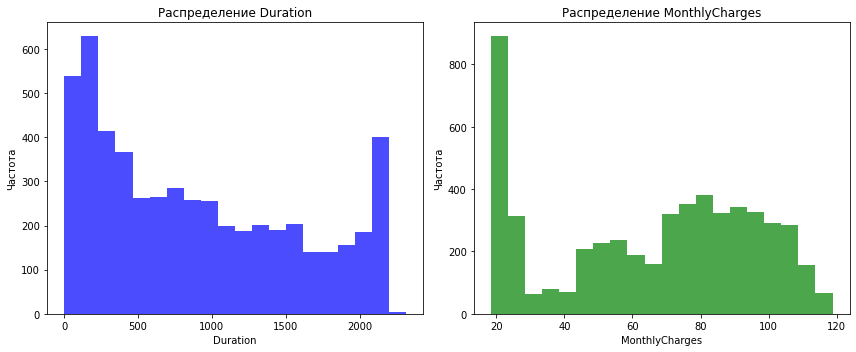

In [60]:
plt.figure(figsize=(12,5))

# График для признака Duration 
plt.subplot(1, 2, 1)
plt.hist(features_train['Duration'], bins=20, color='blue', alpha=0.7)
plt.title('Распределение Duration')
plt.xlabel('Duration')
plt.ylabel('Частота')

# График для признака MonthlyCharges 
plt.subplot(1, 2, 2)
plt.hist(features_train['MonthlyCharges'], bins=20, color='green', alpha=0.7)
plt.title('Распределение MonthlyCharges')
plt.xlabel('MonthlyCharges')
plt.ylabel('Частота')

# Показываем графики
plt.tight_layout()
plt.show()

## Подготовка и обучение моделей машинного обучения

**Модель логистической регрессии.** 

Для определения оптимальных значений гиперпараметров модели используем метод Grid Search.

In [61]:
# зададим список категориальных признаков
categorical_features = ['PaymentMethod']  # Замените это на список ваших категориальных признаков

# создадим ColumnTransformer для кодирования категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

# применимColumnTransformer для обучающих и тестовых данных
features_train_encoded = preprocessor.fit_transform(features_train)
features_test_encoded = preprocessor.transform(features_test)

# зададим сетку значений гиперпараметров
param_grid_LR = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],  
    'penalty': ['l2', 'none']
}

# модель логистической регрессии
model_LR = LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE, solver='lbfgs')

# поиск оптимальных гиперпараметров
grid_search_LR = GridSearchCV(estimator=model_LR, param_grid=param_grid_LR, cv=5, scoring='roc_auc')

# обучаем GridSearchCV на тренировочных данных
grid_search_LR.fit(features_train_encoded, target_train) 

# получаем лучшие параметры из Grid Search
best_params_LR = grid_search_LR.best_params_
print('Лучшие параметры_LR:', best_params_LR)

# получаем средний AUC-ROC на кросс-валидации для лучшей модели
cv_auc_roc_LR = grid_search_LR.best_score_
print('AUC-ROC на кросс-валидации для лучшей модели_LR: {:.2f}'.format(cv_auc_roc_LR))


Лучшие параметры_LR: {'C': 1000, 'penalty': 'l2'}
AUC-ROC на кросс-валидации для лучшей модели_LR: 0.72


**Модель RandomForestClassifier**

In [62]:
# задаем список категориальных признаков
categorical_features = ['PaymentMethod']  

# создаем ColumnTransformer для кодирования категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

features_train_encoded = preprocessor.fit_transform(features_train)
features_test_encoded = preprocessor.transform(features_test)

# определяем сетку гиперпараметров для перебора
param_grid_RFC = {
    'n_estimators': [100, 200, 300],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'class_weight': ['balanced', None]  
}

# создаем модель RandomForestClassifier
model_RFC = RandomForestClassifier(random_state=RANDOM_STATE)

# инициализируем GridSearchCV с моделью и сеткой гиперпараметров
grid_RFC = GridSearchCV(estimator=model_RFC, param_grid=param_grid_RFC, scoring='roc_auc', cv=5)

# обучаем модель с перебором гиперпараметров на тренировочных данных
grid_RFC.fit(features_train_encoded, target_train)

# получаем лучшие параметры и результат на кросс-валидации
best_params_RFC = grid_RFC.best_params_
best_score_RFC = grid_RFC.best_score_

print("Лучшие параметры RandomForestClassifier:", best_params_RFC)
print("Лучший результат AUC-ROC на кросс-валидации:", best_score_RFC)

# получаем лучшую модель
best_model_RFC = grid_RFC.best_estimator_


Лучшие параметры RandomForestClassifier: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Лучший результат AUC-ROC на кросс-валидации: 0.8088730368382226


**Модель CatBoostClassifier**

In [75]:
# задаем список категориальных признаков
categorical_features = ['PaymentMethod']  

# создаем ColumnTransformer для кодирования категориальных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

features_train_encoded = preprocessor.fit_transform(features_train)
features_test_encoded = preprocessor.transform(features_test)

# определите параметры для поиска гиперпараметров
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'l2_leaf_reg': [3, 5, 7],
    'auto_class_weights': ['Balanced', None]
}

# создадим модель CatBoostClassifier
model_CBC = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

# создадим объект GridSearchCV для поиска оптимальных гиперпараметров
grid_search = GridSearchCV(model_CBC, param_grid, cv=5, scoring='roc_auc', verbose=0)

# обучим GridSearchCV на тренировочных данных
grid_search.fit(features_train_encoded, target_train)

# получим лучшие параметры из Grid Search
best_params_CBC = grid_search.best_params_
print('Лучшие параметры CatBoostClassifier:', best_params_CBC)

# получим средний AUC-ROC на кросс-валидации для лучшей модели
cv_auc_roc_CBC = grid_search.best_score_
print('AUC-ROC на кросс-валидации для лучшей модели: {:.2f}'.format(cv_auc_roc_CBC))


Лучшие параметры CatBoostClassifier: {'auto_class_weights': 'Balanced', 'depth': 6, 'iterations': 300, 'l2_leaf_reg': 3, 'learning_rate': 0.2}
AUC-ROC на кросс-валидации для лучшей модели: 0.91


## Выбор лучшей модели

Выведем таблицу с названиями, значениями AUC-ROC и лучшими параметрами для каждой из моделей

In [64]:
results_data = pd.DataFrame({
    'Модель': ['Logistic Regression', 'Random Forest', 'CatBoost Classifier'],
    'AUC-ROC': [cv_auc_roc_LR, best_score_RFC, cv_auc_roc_CBC],
    'Лучшие параметры': [best_params_LR, best_params_RFC, best_params_CBC]
})

print(results_data)

                Модель   AUC-ROC  \
0  Logistic Regression  0.719815   
1        Random Forest  0.808873   
2  CatBoost Classifier  0.908398   

                                    Лучшие параметры  
0                       {'C': 1000, 'penalty': 'l2'}  
1  {'class_weight': None, 'max_depth': 10, 'min_s...  
2  {'auto_class_weights': 'Balanced', 'depth': 6,...  


Вывод: лучшей моделью показала себя модель CatBoost Classifier

**Проверка качества лучшей модели на тестовой выборке**

In [70]:
# создайте модель CatBoostClassifier
model_CBC = CatBoostClassifier(random_state=RANDOM_STATE, verbose=0)

# применим кодирование категориальных признаков
features_test_encoded = preprocessor.transform(features_test)

# обучим модель на данных тренировки
model_CBC.fit(features_train_encoded, target_train)

# получим вероятности классов с лучшей моделью на тестовых данных
probabilities_test_CBC = model_CBC.predict_proba(features_test_encoded)

# выберем вероятности для класса 1 (положительный класс)
probabilities_class_1 = probabilities_test_CBC[:, 1]

# вычислим AUC-ROC на тестовых данных
auc_roc_CBC = roc_auc_score(target_test, probabilities_class_1)
print('AUC-ROC на тестовых данных с лучшими параметрами: {:.2f}'.format(auc_roc_CBC))



AUC-ROC на тестовых данных с лучшими параметрами: 0.90


**Исследование важности признаков лучшей модели**

Для оценки важности признаков в модели CatBoostClassifier воспользуемся атрибутом feature_importances_ и confusion_matrix

In [83]:
print(features_train['PaymentMethod'].unique())

[2 3 1 0]


0:	learn: 0.6440053	total: 1.64ms	remaining: 163ms
1:	learn: 0.6042787	total: 3.22ms	remaining: 158ms
2:	learn: 0.5701211	total: 4.55ms	remaining: 147ms
3:	learn: 0.5419768	total: 6ms	remaining: 144ms
4:	learn: 0.5179946	total: 7.38ms	remaining: 140ms
5:	learn: 0.4961582	total: 8.71ms	remaining: 137ms
6:	learn: 0.4785692	total: 9.46ms	remaining: 126ms
7:	learn: 0.4628362	total: 10.8ms	remaining: 124ms
8:	learn: 0.4503473	total: 11.7ms	remaining: 119ms
9:	learn: 0.4385851	total: 13.1ms	remaining: 118ms
10:	learn: 0.4279647	total: 15.1ms	remaining: 122ms
11:	learn: 0.4183226	total: 17.2ms	remaining: 126ms
12:	learn: 0.4101557	total: 18.8ms	remaining: 126ms
13:	learn: 0.4023433	total: 20.2ms	remaining: 124ms
14:	learn: 0.3948545	total: 21.5ms	remaining: 122ms
15:	learn: 0.3887824	total: 22.8ms	remaining: 120ms
16:	learn: 0.3839732	total: 24.1ms	remaining: 118ms
17:	learn: 0.3792175	total: 25.5ms	remaining: 116ms
18:	learn: 0.3754725	total: 27ms	remaining: 115ms
19:	learn: 0.3712047	total:

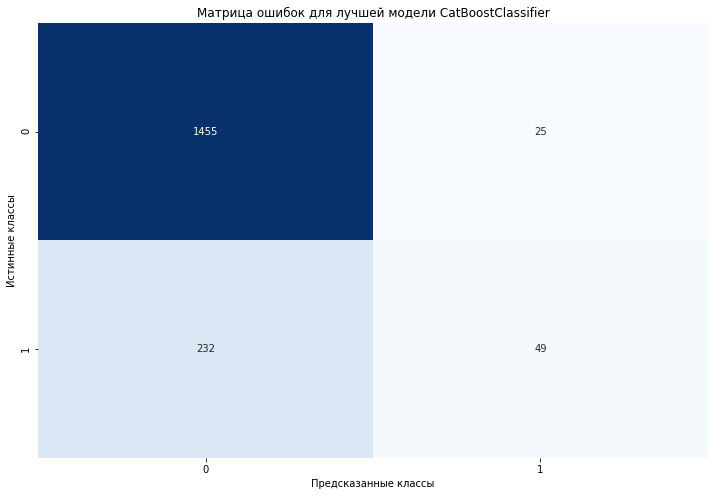

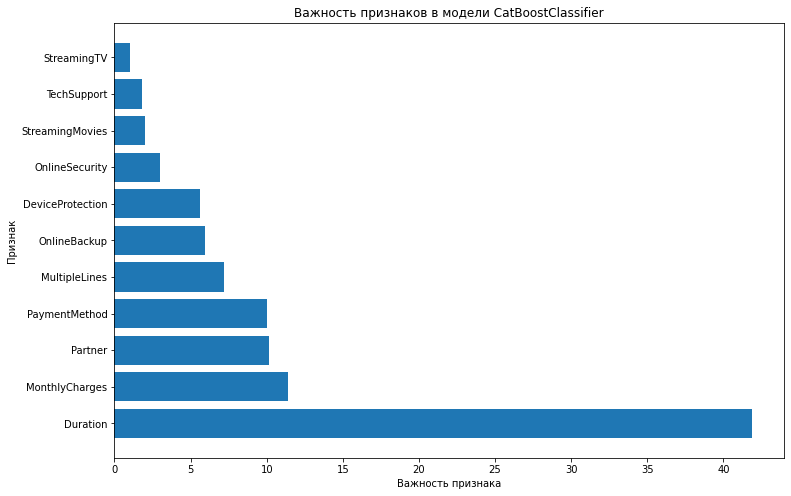

In [85]:
label_encoder = LabelEncoder()

# Примените LabelEncoder к столбцу "PaymentMethod"
features_train['PaymentMethod'] = features_train['PaymentMethod'].astype(str)
features_test['PaymentMethod'] = features_test['PaymentMethod'].astype(str)

features_train['PaymentMethod'] = label_encoder.fit_transform(features_train['PaymentMethod'])
features_test['PaymentMethod'] = label_encoder.transform(features_test['PaymentMethod'])

# Теперь можно обучить модель
model_CBC = CatBoostClassifier(iterations=100, depth=6, learning_rate=0.1, loss_function='Logloss')
model_CBC.fit(features_train, target_train)

# Получите вероятности классов на тестовых данных
probabilities_test_CBC = model_CBC.predict_proba(features_test)

probabilities_class_1 = probabilities_test_CBC[:, 1]

# зададим порог для определения класса (например, 0.5)
threshold = 0.5
predicted_labels = (probabilities_class_1 > threshold).astype(int)

# вычислим матрицу ошибок
confusion = confusion_matrix(target_test, predicted_labels)

# визуализируем матрицу ошибок
plt.figure(figsize=(12, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Матрица ошибок для лучшей модели CatBoostClassifier')

feature_importance = model_CBC.get_feature_importance()

# Создайте DataFrame с важностью признаков
feature_importance_df = pd.DataFrame({'Feature': features_train.columns, 'Importance': feature_importance})

# Отсортируйте признаки по их важности
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# визуализируем важность признаков
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков в модели CatBoostClassifier')
plt.show()

## Отчёт по полученным данным


План отчёта по проекту
1. Анализ эффективности выполнения проекта (какие пункты были выполнены, какие – нет).
2. Трудности во время работы над проектом.
3. Ключевые шаги в решении задач.
4. Описание итоговой модель, её гиперпараметры и качество.
5. Список признаков,  используемых для обучения лучшей модели (с описанием их предобработки).

**1. Анализ эффективности выполнения проекта:**
<br><br>
Выполненные пункты:
<br>
- загрузка и изучение данных из четырех исходных датасетов: contract, internet, personal и phone;
- объединение данных в один датасет на основе уникального идентификатора клиента (customerID);
- изменение типов данных некоторых признаков (BeginDate, EndDate, MonthlyCharges, TotalCharges);
- создание целевой переменной (Target) для построения модели машинного обучения для прогнозирования оттока клиентов;
- обработка пропущенных значений и категориальных признаков;
- проверка на дисбаланс классов и анализ корреляции признаков;
- выбор и подготовка признаков для обучения моделей;
- разделение данных на обучающую и тестовую выборки;
- применение кодирования и масштабирования для числовых признаков;
- обучение трех различных моделей машинного обучения: логистической регрессии, RandomForestClassifier и CatBoostClassifier;
- оптимизация гиперпараметров моделей с использованием Grid Search;
- выбор лучшей модели на основе кросс-валидации и метрики AUC-ROC;
- оценка качества лучшей модели на тестовой выборке.
- исследование важности признаков в лучшей модели с использованием атрибута feature_importances_;
<br>
Не выполненные пункты:
<br>
- дополнительный анализ признаков и генерация новых признаков.
- более детальное исследование важности признаков с применением дополнительных методов, таких как SHAP или permutation feature importance.
<br>

**2. Трудности во время работы над проектом:**
<br><br>
Обработка и объединение данных из нескольких исходных датасетов с пропущенными значениями и различными типами признаков представляла собой значительную сложность.
Подбор оптимальных гиперпараметров для моделей требовал много вычислительных ресурсов и времени.
Работа с дисбалансом классов и выбор наилучшего метода балансировки классов также были нетривиальными задачами.
<br>
<br>
**3. Ключевые шаги в решении задач:**
 <br><br>
Загрузка, изучение и объединение данных.
Предобработка данных, включая обработку пропущенных значений и категориальных признаков.
Подготовка признаков для обучения моделей, включая создание целевой переменной.
Разделение данных на обучающую и тестовую выборки.
Обучение и оптимизация моделей машинного обучения с использованием Grid Search.
Выбор лучшей модели и оценка её качества на тестовой выборке.
Исследование важности признаков в лучшей модели.
<br>
<br>
**4. Описание итоговой модели, её гиперпараметры и качество:**
<br><br>
Итоговая модель: CatBoostClassifier
<br>
Лучшие гиперпараметры:
- 'auto_class_weights': 'Balanced'
- 'depth': 6
- 'iterations': 300
- 'l2_leaf_reg': 3
- 'learning_rate': 0.2
- качество на кросс-валидации (AUC-ROC): 0.908398
- качество на тестовых данных с лучшими параметрами (AUC-ROC) : 0.90
<br>

**5. Список признаков, используемых для обучения лучшей модели (с описанием их предобработки):**
<br>
- Target – целевая переменная, показывающая отток клиента, создана на основе признака EndDate;
- Duration – признак, представляющий длительность жизни клиента в днях, вычисленный на основе BeginDate и EndDate;
- MultipleLines, OnlineBackup, Partner, StreamingMovies, DeviceProtection, StreamingTV, OnlineSecurity, TechSupport – категориальные бинарные признаки, закодированные числовыми значениями (0 и 1);
- PaymentMethod – категориальный признак, который был закодирован методом One-Hot Encoding (OHE);
- MonthlyCharges – месячные платежи клиента, преобразованные в числовой формат.
<br><br>
Итоговая модель CatBoostClassifier достигла хорошего качества с AUC-ROC на тестовой выборке равным 0.90. Модель способна прогнозировать отток клиентов с высокой точностью и является наилучшей из рассмотренных. 
<br><br>
Признаки для прогнозирования оттока в порядке убывания важности:
- Duration,
- MonthlyCharges,
- Partner,
- PaymentMethod,
- MultipleLines, 
- OnlineBackup,
- DeviceProtection,
- OnlineSecurity,
- StreamingMovies,
- TechSupport,
- StreamingTV.
